# CIS 5450 Homework 2: SQL and DuckDB
## Due: Friday, October 11 2024, 10:00pm EST
### Worth 95 points in total (25 manually graded)

Welcome to Homework 2! By now, you should be familiar with the world of data science and the Pandas library. This assignment focuses on helping you get to grips with two new tools: SQL and DuckDB.

Through this homework, we will be working with SQL by exploring a [Indego](https://www.rideindego.com/) dataset containing bike rides, stations and weather data. We will then expand our exploration with DuckDB and finish by comparing the two with Pandas.

 <!-- We will finish off the homework with some text analysis. -->

We are introducing a lot of new things in this homework, and this is often where students start to get lost. Thus, we **strongly** encourage you to review the slides/material as you work through this assignment.

**Before you begin:**
- Be sure to click "Copy to Drive" to make sure you're working on your own personal version of the homework
- Check the pinned FAQ post on Ed for updates! If you have been stuck, chances are other students have also faced similar problems.

##Part 0: Libraries and Set Up Jargon

In [192]:
import pandas as pd

In [193]:
!pip3 install penngrader-client
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install geopy
!pip install -U kaleido

In [194]:
from penngrader.grader import *
import pandas as pd
import datetime as dt
import geopy.distance as gp
import matplotlib.image as mpimg
import plotly.express as px
# import re
import pandasql as ps #SQL on Pandas Dataframe
import nltk
nltk.download('punkt')
import duckdb
from wordcloud import WordCloud
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
from PIL import Image
# from collections import Counter
# import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [195]:
# Three datasets we're using
! wget -nc https://storage.googleapis.com/penn-cis5450/indego_trips.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/indego_stations.csv
! wget -nc https://storage.googleapis.com/penn-cis5450/weather_2022_PHL.csv

File ‘indego_trips.csv’ already there; not retrieving.

File ‘indego_stations.csv’ already there; not retrieving.

File ‘weather_2022_PHL.csv’ already there; not retrieving.



###PennGrader Setup

In [196]:
# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW
# TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 86393681 # YOUR PENN-ID GOES HERE AS AN INTEGER #
SECRET = STUDENT_ID

In [197]:
%%writefile config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Overwriting config.yaml


In [198]:
grader = PennGrader('config.yaml', 'cis5450_fall24_HW2', STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 86393681

Make sure this correct or we will not be able to store your grade


## Biking in Philadelphia

<br>
<center><img src = "https://whyy.org/wp-content/uploads/2021/11/AP-indego-bike-share-philly-docking-station-110421-768x512.jpg" width= "500" align ="center"/></center>
<br>

I'm sure in your time in Philadelphia so far you've come across these blue bikes and stations. Indego is the company responsible for this bike sharing ride system, and they make data on bike trips available to the public. This data can not only be useful to get information of how people in Philly use bikes, but it can give information on the most visited places in the city which can be useful for city planners and business owners.


In this homework, we'll be exploring some data about bikes including:

*   Trips: data about bike trips during the first week of October 2022.

*   Stations: data about bike stations, their ID and Name.

*   Weather: data about the weather in Philadelphia during 2022.


We'll be parsing this data into dataframes and relations, and then exploring how to query and assemble the tables into results. We will primarily be using DuckDB, but for some of the initial questions, we will ask you to perform the same operations in Pandas as well, so as to familiarize you with the differences and similarities of the two.

For the final part of this Homework, we'll use a fourth database with restaurants and reviews, and perform some text analysis.

## Part 1: Load & Process our Datasets [15 points total]

Before we get into the data, we first need to load and clean our datasets.

### Metadata
You'll be working with three CSV files:
- `indego_trips.csv`
- `indego_stations.csv`
- `weather_2022_PHL.csv`

The file `indego_trips.csv` contains data about each trip, like the origin station, destination station and duration.

The file `indego_stations.csv` includes information about stations and their status in January 2023.

The file `weather_2022_PHL.csv` has one row per day during 2022 and shows weather information.


**TODO**:
* Load `indego_trips.csv` and save the data to a dataframe called `trips_df`.
* Load `indego_stations.csv` and save the data to a dataframe called `stations_df`.
* Load `weather_2022_PHL.csv` and save the data to a dataframe called `weather_df`.


In [199]:
# TODO: Import the datasets to pandas dataframes -- make sure the dataframes are named correctly!
trips_df = pd.read_csv("indego_trips.csv")
stations_df = pd.read_csv("indego_stations.csv")
weather_df = pd.read_csv("weather_2022_PHL.csv")

In [200]:
# view trips_df using .head() to make sure the import was successful
# trips_df.head()
# Not running to make file size smaller

In [201]:
# view stations_df using .head() to make sure the import was successful
# stations_df.head()
# Not running to make file size smaller

In [202]:
# view weather_df using .head() to make sure the import was successful
# weather_df.head()
# Not running to make file size smaller

###1.1 Data Preprocessing

Next, we are going to want to clean up our dataframes, namely `trips_df` and `stations_df`, by 1) fixing columns, 2) changing datatypes, 3) handling nulls.

First, let us view the first few rows of `trips_df`. You may also call `.info()` and additionally check the cardinality of each column to view the specifics of the dataframe. This is a good first step to take for Exploratory Data Analysis (EDA).

#### 1.1.1 Cleaning `trips_df` [8 points]

`.info()` gives us meaningful information regarding columns, their types, and the amount of nulls, based on which we can now clean our dataframe.

Perform these steps and save results on a new dataframe: `trips_cleaned_df`

**TODO**:
* Drop the column `plan_duration`. We already have that information in the column `passholder_type`, which is more understandable.
* Drop the rows where `end_station` is 3000. This is a virtual station used for maintainance, and doesn't represent a real trip.
* Drop all rows with null values.
* Cast the columns:
  -  `start_time`, `end_time`, `trip_route_category`, `passholder_type`, `bike_type` as **string**. (Cast to 'string' and not 'str')
  - `bike_id` as **int**.
* Sort results by `trip_id` ascending
* Reset and drop the index and save results as `trips_cleaned_df`

After performing these steps, `trips_cleaned_df` should have the following schema:

**Final Schema**:
>trip_id | duration | start_time | end_time | start_station | start_lat | start_lon | end_station |  end_lat | end_lon |  bike_id | trip_route_category | passholder_type | bike_type
>--- | --- | --- |--- | --- | --- | --- |--- | --- | --- |--- |--- | --- | --- |

In [203]:
#view info of trips_df
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15502 entries, 0 to 15501
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip_id              15502 non-null  int64  
 1   duration             15502 non-null  int64  
 2   start_time           15502 non-null  object 
 3   end_time             15502 non-null  object 
 4   start_station        15477 non-null  float64
 5   start_lat            15477 non-null  float64
 6   start_lon            15477 non-null  float64
 7   end_station          15477 non-null  float64
 8   end_lat              15255 non-null  float64
 9   end_lon              15255 non-null  float64
 10  bike_id              15477 non-null  object 
 11  plan_duration        15477 non-null  float64
 12  trip_route_category  15477 non-null  object 
 13  passholder_type      15477 non-null  object 
 14  bike_type            15477 non-null  object 
dtypes: float64(7), int64(2), object(6)
m

In [204]:
# TODO: drop plan_duration
trips_cleaned_df = trips_df.drop(columns = ["plan_duration"])


In [205]:
# TODO: drop rows with irrelevant end_station
trips_cleaned_df = trips_cleaned_df[trips_cleaned_df['end_station'] != 3000]

In [206]:
# TODO: drop rows with null values
trips_cleaned_df = trips_cleaned_df.dropna()

In [207]:
# TODO: cast the types of the columns
trips_cleaned_df['start_time'] = trips_cleaned_df['start_time'].astype('string')
trips_cleaned_df['end_time'] = trips_cleaned_df['end_time'].astype('string')
trips_cleaned_df['trip_route_category'] = trips_cleaned_df['trip_route_category'].astype('string')
trips_cleaned_df['passholder_type'] = trips_cleaned_df['passholder_type'].astype('string')
trips_cleaned_df['bike_type'] = trips_cleaned_df['bike_type'].astype('string')
trips_cleaned_df['bike_id'] = trips_cleaned_df['bike_id'].astype('int')

In [208]:
# TODO: sort the results
trips_cleaned_df = trips_cleaned_df.sort_values(by = 'trip_id', ascending = True)


In [209]:
# TODO: drop the index and save the results
trips_cleaned_df = trips_cleaned_df.reset_index(drop = True)

In [210]:
# 4 points
grader.grade(test_case_id = 'test_cleaning_trips', answer = trips_cleaned_df)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Now we are going to clean up the start_time and end_time columns so that they are easier to use. We will be using Regex in this section to separate out the date and the time from the entries.

**TODO**:
* Cast the type of `start_date` and `end_date` to 'string', NOT 'str'
* Fill in the Regex patterns to retrieve first the date, and then the time, found in each entry.
* Extract the relevant parts of each column and populate new columns called the following: `date_start`, `time_start`, `date_end`, `time_end`. Note that the datetime type does contain both date and time, but that we are wanting to explore your Regex capabilities :)
* Cast the new date columns as `datetime64[ns]`, using pd.to_datetime() and the format as '%m/%d/%Y'
* Remove columns `start_time`, `end_time`

In [211]:
#view trips_cleaned_df using .head()
# trips_cleaned_df.head()
# Not running to make file size smaller

In [212]:
# TODO: cast the types of start_time and end_time to 'string'
trips_cleaned_df['start_time'] = trips_cleaned_df['start_time'].astype('string')
trips_cleaned_df['end_time'] = trips_cleaned_df['end_time'].astype('string')

In [213]:
# TODO: fill in the pattern to retrieve the date of each entry
# HINT: think about the unique syntax of the date section, the different variations it can appear in
date_pattern =r'(\d{1,2}/\d{1,2}/\d{4})'

In [214]:
# TODO: fill in the pattern to retrieve the time of each entry
# HINT: think about the unique syntax of the time section, the different variations it can appear in
time_pattern =r'(\d{1,2}:\d{2})'

In [215]:
# TODO: populate columns date_start, time_start, date_end, time_end
trips_cleaned_df['date_start'] = trips_cleaned_df['start_time'].str.extract(date_pattern)
trips_cleaned_df['time_start'] = trips_cleaned_df['start_time'].str.extract(time_pattern)
trips_cleaned_df['date_end'] = trips_cleaned_df['end_time'].str.extract(date_pattern)
trips_cleaned_df['time_end'] = trips_cleaned_df['end_time'].str.extract(time_pattern)



In [216]:
# TODO: cast the date columns to as datetime64[ns]
trips_cleaned_df['date_start'] = pd.to_datetime(trips_cleaned_df['date_start'], format='%m/%d/%Y')
trips_cleaned_df['date_end'] = pd.to_datetime(trips_cleaned_df['date_end'], format='%m/%d/%Y')

In [217]:
# TODO: drop the start_time and end_time
trips_cleaned_df = trips_cleaned_df.drop(columns = ['start_time', 'end_time'])
trips_cleaned_df = trips_cleaned_df[['trip_id', 'duration', 'start_station', 'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category', 'passholder_type', 'bike_type', 'date_start', 'time_start', 'date_end', 'time_end']]

In [218]:
# 4 points
grader.grade(test_case_id = 'test_regex_trips', answer = trips_cleaned_df)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.2 Processing Stations [3 Points]

`stations_df` contains information on Indego stations across the city. We will clean this df by removing Inactive stations and stations created after October 2022.

Perform these steps and assign the cleaned dataframe to `stations_cleaned_df`.

**TODO**:
* **Drop** the stations that have an **Inactive** status.
* **Cast** column `day_of_go_live_date` as datetime64[ns].
* **Drop** the stations that were created **after 10/7/2022** since this is the last date of rides we are analyzing.
* **Drop** the columns `day_of_go_live_date` and `status`
* **Create** a new column called `is_west_philly` that is True if zone is 2 or 3 and False otherwise.
* **Save** the resulting dataframe as `stations_cleaned_df`, and sort it by `station_id` ascending


After performing these steps, `stations_cleaned_df` should have the following schema:


**Final Schema**:
>station_id | station_name | zone | is_west_philly
>--- | --- | --- |--- |

In [219]:
#view info of stations_df
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   station_id           203 non-null    int64 
 1   station_name         203 non-null    object
 2   day_of_go_live_date  203 non-null    object
 3   status               203 non-null    object
 4   zone                 203 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 8.1+ KB


In [220]:
# TODO: Drop the stations that have an Inactive status.
stations_df = stations_df[stations_df['status'] != 'Inactive']

In [221]:
# TODO: Cast column day_of_go_live_date as datetime64[ns].
stations_df['day_of_go_live_date'] = pd.to_datetime(stations_df['day_of_go_live_date'], format='%m/%d/%Y')

<ipython-input-221-37858bfc3479>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_df['day_of_go_live_date'] = pd.to_datetime(stations_df['day_of_go_live_date'], format='%m/%d/%Y')


In [222]:
# TODO: Drop the stations that were created after 10/7/2022.
stations_df = stations_df[stations_df['day_of_go_live_date'] <= '2022-10-07']


In [223]:
# TODO: Drop day_of_go_live_date and status columns
stations_df = stations_df.drop(columns = ['day_of_go_live_date', 'status'])

In [224]:
# TODO: Create a new column called is_west_philly that is True if zone is 2 or 3 and False otherwise.
stations_df['is_west_philly'] = stations_df['zone'].apply(lambda x: True if x == 2 or x == 3 else False)

In [225]:
# TODO: Sort by station_id ascending
stations_df = stations_df.sort_values(by = 'station_id', ascending = True)

In [226]:
# TODO: Reset and drop the index, and save the resulting dataframe as stations_cleaned_df
stations_cleaned_df = stations_df.reset_index(drop = True)

In [227]:
# 3 points
grader.grade(test_case_id = 'test_cleaning_stations', answer = stations_cleaned_df)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 1.1.3 Cleaning the weather [4 Points]
Then, let's clean `weather_df` and make it usable. We are going to make two different datasets, one for the actual data, and another for the record-holding data.

**TODO**:
* Create `actual_weather_cleaned_df` and only keep the following 5 columns:
     * `date`, `actual_mean_temp`, `actual_min_temp`, `actual_max_temp`, `actual_precipitation`
* Create `record_weather_cleaned_df` and only keep the following 4 columns:
     * `date`, `record_min_temp`, `record_max_temp`, `record_precipitation`

Then for both datasets:
* Convert column `date` into type `datetime64[ns]`.
* Keep only the rows from 9/1/2022 to 10/31/2022, inclusive.
* Sort by column `date` descending.
* Reset and drop the index.

After performing these steps, `actual_weather_cleaned_df` should have the following schema:

**Final Schema**:
>date | actual_mean_temp | actual_min_temp | actual_max_temp | actual_precipitation
>--- | --- | --- |--- |--- |

... and `record_weather_cleaned_df` should have the following schema:

**Final Schema**:
>date | record_min_temp | record_max_temp | record_precipitation
>--- | --- | --- |--- |

In [228]:
#view info of weather_df
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   365 non-null    object 
 1   actual_mean_temp       365 non-null    int64  
 2   actual_min_temp        365 non-null    int64  
 3   actual_max_temp        365 non-null    int64  
 4   average_min_temp       365 non-null    int64  
 5   average_max_temp       365 non-null    int64  
 6   record_min_temp        365 non-null    int64  
 7   record_max_temp        365 non-null    int64  
 8   record_min_temp_year   365 non-null    int64  
 9   record_max_temp_year   365 non-null    int64  
 10  actual_precipitation   365 non-null    float64
 11  average_precipitation  365 non-null    float64
 12  record_precipitation   365 non-null    float64
dtypes: float64(3), int64(9), object(1)
memory usage: 37.2+ KB


In [229]:
# TODO: create actual_weather_cleaned_df
actual_weather_cleaned_df = weather_df[['date', 'actual_mean_temp', 'actual_min_temp', 'actual_max_temp', 'actual_precipitation']]

In [230]:
# TODO: create record_weather_cleaned_df
record_weather_cleaned_df = weather_df[['date', 'record_min_temp', 'record_max_temp', 'record_precipitation']]

In [231]:
# TODO: for both datasets, convert column 'date' into type datetime64[ns]
actual_weather_cleaned_df['date'] = pd.to_datetime(actual_weather_cleaned_df['date'], format='%m/%d/%Y')
record_weather_cleaned_df['date'] = pd.to_datetime(record_weather_cleaned_df['date'], format='%m/%d/%Y')

<ipython-input-231-601e2b786d8e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_weather_cleaned_df['date'] = pd.to_datetime(actual_weather_cleaned_df['date'], format='%m/%d/%Y')
<ipython-input-231-601e2b786d8e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  record_weather_cleaned_df['date'] = pd.to_datetime(record_weather_cleaned_df['date'], format='%m/%d/%Y')


In [232]:
# TODO: for both datasets, keep only the rows from 9/1/2022 to 10/31/2022, inclusive
actual_weather_cleaned_df = actual_weather_cleaned_df[(actual_weather_cleaned_df['date'] >= '2022-09-01') & (actual_weather_cleaned_df['date'] <= '2022-10-31')]
record_weather_cleaned_df = record_weather_cleaned_df[(record_weather_cleaned_df['date'] >= '2022-09-01') & (record_weather_cleaned_df['date'] <= '2022-10-31')]

In [233]:
# TODO: for both datasets, sort by column 'date' descending
actual_weather_cleaned_df = actual_weather_cleaned_df.sort_values(by = 'date', ascending = False)
record_weather_cleaned_df = record_weather_cleaned_df.sort_values(by = 'date', ascending = False)

In [234]:
# TODO: for both datasets, reset and drop the index
actual_weather_cleaned_df = actual_weather_cleaned_df.reset_index(drop = True)
record_weather_cleaned_df = record_weather_cleaned_df.reset_index(drop = True)

In [235]:
# 4 points
grader.grade(test_case_id = 'test_cleaning_weather', answer = [actual_weather_cleaned_df, record_weather_cleaned_df])

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 2: DuckDB [55 points total]

### 👇👇👇 IMPORTANT: Pay VERY CLOSE attention to this style guide! 👇👇👇

The typical flow to use duckdb is as follows:
1. Write a SQL query in the form of a string
    - **String Syntax:** use triple quotes `"""<your query>"""` to write multi-line strings
    - **Aliases are your friend:** if there are very long table names or you find yourself needed to declare the source (common during join tasks), it's almost always optimal to alias your tables with short INTUITIVE alias names
    - **New Clauses New Line:** each of the main SQL clauses (`SELECT`, `FROM`, `WHERE`, etc.) should begin on a new line
    - **Use Indentation:** if there are many components for a single clause, separate them out with new <ins>indented</ins> lines.

    Example below:
    ```SQL
    """
    SELECT ltn.some_id, SUM(stn.some_value) AS total
    FROM long_table_name AS ltn
         INNER JOIN short_table_name AS stn
            ON ltn.common_key = stn.common_key
         INNER JOIN med_table_name AS mtn
            ON ltn.other_key = mtn.other_key
    WHERE ltn.col1 > value
         AND stn.col2 <= another_value
         AND mtn.col3 != something_else
    GROUP BY ltn.some_id
    ORDER BY total
    """
    ```
2. Run the query using **duckdb.sql(your_query)**

Duckdb and pandasql are convenient in that they allow you to reference the dataframes that are currently defined in your notebook, so you will be able to fully utilize the dataframes that you have created above!

Given that it is a brand new language, we wanted to give you a chance to directly compare the similarities/differences of the pandas that you already know and the SQL that you are about to learn. SQL queries may take up to a minute to run.

**⚠WARNING: DO NOT USE PANDAS FOR SQL QUESTIONS OR VICE-VERSA! OTHERWISE, YOU WON'T RECEIVE CREDITS FOR THESE QUESTIONS**

In [236]:
#TODO: Run this cell to understand how Duck DB connects to local dataframes and queries them
test_duckdb_query = """
SELECT *
FROM actual_weather_cleaned_df
LIMIT 10
"""

duckdb.sql(test_duckdb_query)

┌─────────────────────┬──────────────────┬─────────────────┬─────────────────┬──────────────────────┐
│        date         │ actual_mean_temp │ actual_min_temp │ actual_max_temp │ actual_precipitation │
│    timestamp_ns     │      int64       │      int64      │      int64      │        double        │
├─────────────────────┼──────────────────┼─────────────────┼─────────────────┼──────────────────────┤
│ 2022-10-31 00:00:00 │               47 │              40 │              54 │                  0.0 │
│ 2022-10-30 00:00:00 │               53 │              45 │              60 │                  0.0 │
│ 2022-10-29 00:00:00 │               60 │              50 │              70 │                 0.03 │
│ 2022-10-28 00:00:00 │               63 │              49 │              76 │                  0.0 │
│ 2022-10-27 00:00:00 │               57 │              46 │              67 │                  0.0 │
│ 2022-10-26 00:00:00 │               59 │              50 │              67 │    

### 2.1 Comparing Rides by Passholders [17 points]

#### 2.1.1 How many rides were taken per passholder type? [3 points]

The dataframe `trips_cleaned_df` contains information for each ride. We want to know which of these rides were taken per passholder type (Day Pass, Indego30, Indego365), and how many such rides were taken.

**TODO:**
*  Create a DuckDB query that counts the number of trips taken per passholder type.
*  The resulting table should have the column `passholder_type` that contains the pass names and another column `trip_count` that is the count of the number of trips taken on that pass.
*  Sort this table by `trip_count` in descending order.

**Note:** Do not modify the lines where we are calling the Duck DB SQL engine, as this line converts your results to a Pandas dataframe for our test cases.

**Hint:** It would be helpful to use the `GROUP BY` and `ORDER BY` statements in SQL. Documentation for the `GROUP BY` statement can be found [here](https://www.w3schools.com/sql/sql_groupby.asp) and `ORDER BY` statement can be found [here](https://www.w3schools.com/sql/sql_orderby.asp).

**Final Schema:**

>passholder_type | trip_count
>--- | ---

In [237]:
# TODO: Use Duck DB to get the total number of trips by passholder type
passholder_count_query = """
FROM trips_cleaned_df AS trips
SELECT trips.passholder_type, COUNT(*) AS trip_count
GROUP BY trips.passholder_type
ORDER BY trip_count DESC
"""
passholder_count = duckdb.sql(passholder_count_query).df()


In [238]:
# 3 Points
grader.grade(test_case_id = 'test_passholder_count', answer = (passholder_count, passholder_count_query))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.2 What was the average distance between the start and end point of the ride by passholder type? [5 points]

We are now interested in what the average displacement was between the start and end of the ride by each passholder type.

**TODO:**
*  Create a (Python) function called `calculate_distance` that returns the distance in miles between two longitude/latitude coordinates. The input parameters should be `start_lat`, `start_lon`, `end_lat`, `end_lon`
*  Create a function in Duck DB using the `create_function` functionality in Duck DB. Name this function `distance`. The input/output datatypes for this function should all be `float`.
*  Use this function **inside** a Duck DB query to find the average trip displacement by passholder type for **non-roundtrip rides** from `trips_cleaned_df`.
*  Sort the table by the average displacement in descending order.

Documentation on using Python functions in Duck DB can be found [here](https://duckdb.org/docs/api/python/function). The "Python Function API" and "Creating Functions" sections would be most helpful.

**Hint:** Use the GeoPy Distance module to help create your function, which has already been imported for you at the top of this notebook! Documentation on this module can be found [here](https://geopy.readthedocs.io/en/stable/#module-geopy.distance).

**Final Schema:**
>passholder_type | avg_displacement
>--- | ---

In [239]:
# TODO: Finish the rest of the calculate_distance function by using the GeoPy Distance module.
from geopy import distance
import duckdb

def calculate_distance(start_lat, start_lon, end_lat, end_lon):
  dist=distance.distance((start_lat,start_lon), (end_lat,end_lon)).miles
  return dist

The following test case is not graded but given to you all as a spot check. If you don't receive a hint from the test case you are good to go!

In [240]:
# 0 point
grader.grade(test_case_id = 'test_distance_function', answer = calculate_distance(30.4515, -91.1871, 29.9509, -90.0758))

Correct! You earned 0/0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [241]:
# DO NOT EDIT
try:
  duckdb.remove_function("distance")
except:
  pass

# TODO: Use the calculate_distance function to create a Duck DB function with the correct parameters


In [242]:
# TODO: Use Duck DB to find the average displacement for non-roundtrip rides for each passholder type.
duckdb.create_function("distance", calculate_distance, [float, float, float, float], float)
distance_query = """
SELECT trips.passholder_type, AVG(distance(trips.start_lat, trips.start_lon, trips.end_lat, trips.end_lon)) AS avg_displacement
FROM trips_cleaned_df AS trips
WHERE trips.trip_route_category != 'Round Trip'
GROUP BY trips.passholder_type
"""

passholder_distance = duckdb.sql(distance_query).df()
passholder_distance

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,passholder_type,avg_displacement
0,Day Pass,1.136250
1,Indego30,1.066460
2,Indego365,1.050815


In [243]:
# 5 points
grader.grade(test_case_id = 'test_passholder_distance', answer = passholder_distance)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.3 What is the distribution of electric vs standard bikes for each type of pass? [4 points]

**TODO:**
*  Create a DuckDB query that finds the percentage of rides that used an electric bike for each type of pass from `trips_cleaned_df`.
*  The resulting table should have the column `passholder_type` and `electric_pct`, which shows what percentage of the rides taken for that pass were on electric bikes.
*  For the `electric_pct` column, scale the percentages to be between 0 and 100 (e.g. 40.4% = 40.4) and rounded to 1 decimal place.
*  Sort the table by `electric_pct` in descending order.
*  Do not modify the variable name of the query string (passholder_bike_type_query), as this variable will be passed into the test case.

**Hint:** For documentation on rounding in SQL, see the documentation [here](https://www.w3schools.com/sql/func_mysql_round.asp). For documentation on the `CASE` statement, see the documentation [here](https://www.w3schools.com/sql/sql_case.asp).

**Final Schema:**
>passholder_type | electric_pct
>--- | ---

In [244]:
# TODO: Create a Duck DB query that finds the percentage of rides on an electric bike for each type of passholder.
passholder_bike_type_query = """
SELECT trips.passholder_type, ROUND(SUM(CASE WHEN trips.bike_type = 'electric' THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 1) AS electric_pct
FROM trips_cleaned_df AS trips
GROUP BY trips.passholder_type
ORDER BY electric_pct DESC
"""
passholder_bike_type = duckdb.sql(passholder_bike_type_query).df()


In [245]:
# 4 points
grader.grade(test_case_id = 'test_passholder_bike_type', answer = (passholder_bike_type, passholder_bike_type_query))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.1.4 What are the most popular rides for each day of the week? [4 points]

We want to understand what are the most popular days of the week for bike rides for each type of pass in `trips_cleaned_df`.

**TODO:**
*  Create a query using Duck DB that returns a table with the following schema:

>Day of Week | Number of Days | Day Pass | Indego30 | Indego365
>--- | --- | --- |--- | ---

*  The `Day of Week` column indicates the specific day of the week when the rides occurred. The `Day Pass`, `Indego30`, and `Indego365` columns represent the total number of rides for each type of pass on that particular day of the week. For example, if a row lists "Monday" in the Day of Week column, the value in the Day Pass column should reflect the total number of rides taken with a Day Pass on all Mondays throughout the dataset.
*  `Number of Days` is the number of dates in our dataset that fall on that row's day of the week.
*  Sort the dataframe to start from Monday and end on Sunday.

**Hint:** Look at the documentation [here](https://www.w3schools.com/sql/func_mysql_dayname.asp) to extract day of week names in SQL. Look at the documentation [here](https://www.w3schools.com/sql/sql_distinct.asp) to figure out how to count the distinct dates for each day of the week in the `Number of Days` column.

**Hint:** If we are defining a column alias in SQL as a string with spaces (e.g. "Day of Week"), we have to put it in double quotes inside of the query. To reference a string, only single quotes are needed (e.g. 'Monday').

**Hint:** To sort the dataframe by the correct days of the week, consider using a [CASE statement](https://www.w3schools.com/sql/sql_case.asp) to assign each day of the week to a number, then sorting by this assignment.

In [246]:
# TODO: Create a Duck DB query in the schema specified above that counts the number of bike rides per passholder type on every day of the week.
day_of_week_query = """
SELECT
    DAYNAME(trips.date_start) AS "Day of Week",
    COUNT(DISTINCT trips.date_start) AS "Number of Days",
    COUNT(CASE WHEN trips.passholder_type = 'Day Pass' THEN 1 END) AS "Day Pass",
    COUNT(CASE WHEN trips.passholder_type = 'Indego30' THEN 1 END) AS Indego30,
    COUNT(CASE WHEN trips.passholder_type = 'Indego365' THEN 1 END) AS Indego365
FROM trips_cleaned_df AS trips
GROUP BY "Day of Week"
ORDER BY CASE
    WHEN "Day of Week" = 'Monday' THEN 1
    WHEN "Day of Week" = 'Tuesday' THEN 2
    WHEN "Day of Week" = 'Wednesday' THEN 3
    WHEN "Day of Week" = 'Thursday' THEN 4
    WHEN "Day of Week" = 'Friday' THEN 5
    WHEN "Day of Week" = 'Saturday' THEN 6
    WHEN "Day of Week" = 'Sunday' THEN 7
    END
"""

day_of_week = duckdb.sql(day_of_week_query).df()




In [247]:
# 4 points
grader.grade(test_case_id = 'test_day_of_week_count', answer = day_of_week)

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### Reflect: What do you think? [1 point]

Which day of the week did Indego30 passholders ride the most? What can you say about the distribution of the number of rides for each day of the week? Do we have enough data to draw a fair conclusion about our data or rider behavior?

In [248]:
# TODO: Answer the above reflection questions.
your_answer = "Indego30 passholders take most trips on Thursday. The average number of rides per weekday (1851.6) is significantly higher than the average number of rides per day on the weekend (939.5). Without a larger dataset and more context (like seasonal variation and external influences), it's difficult to draw definitive conclusions about long-term rider behavior.  "

In [249]:
# 1 point
grader.grade(test_case_id = 'test_reflection', answer = your_answer)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2 Destinations from Amtrak Station [9 points]
As you might imagine, Amtrak Station is a very important location for Indego, as there is a lot of people that either want to get there for a train ride or are exiting from there to visit Philadelphia. Thus, we want to learn about where people tend to go once they leave Amtrak Station.

You will create this dataset using SQL (Duck DB)

#### 2.2.1 Names not numbers [3 points]
We will now use `stations_cleaned_df` to modify our `trips_cleaned_df`. If you look at the rides data, you will notice that both start and end station columns have numbers corresponding to the station ID listed. Using the station ID listed in stations_df, we want to include station names instead of station IDs in our `trips_final_df`.

**TODO** (`SQL`):
* Create a function called `station_ids_to_names_dict` that uses `stations_cleaned_df` to map station IDs with their corresponding name. If a mapping does not exist from a station ID, return "Unknown" as the station name.
* Convert this Python function into a Duck DB function you can use in a query. Name this function `station_ids_dict`. The input type should be an int and the output type should be a string.
* Create a query with the final output being a new dataframe called `trips_final_df` which you will use in 2.2.2.
* Replace the IDs in the `start_station` and `end_station` columns with the corresponding station name.
* Sort the resulting table by the trip_id (in ascending order).

**Hint:** Case the stations IDs into integers before you feed them into your Duck DB function.

**Hint:** In order to convert the station IDs to station names, a Python dictionary may be helpful. See the documentation [here](https://www.w3schools.com/PYTHON/python_dictionaries.asp).

**Final Schema:**

> | trip_id | duration | start_station | start_lat | start_lon | end_station | end_lat | end_lon | bike_id | trip_route_category | passholder_type | bike_type | date_start | time_start | date_end | time_end |
> |---------|----------|---------------|-----------|-----------|-------------|---------|---------|---------|---------------------|-----------------|-----------|------------|------------|----------|----------|

A downside of using SQL to edit a table's columns is that we have to explicitly list out all of the columns again in the query.



In [250]:
# TODO: Create a function named station_ids_to_names_dict that takes in a station ID (numerical) and outputs its corresponding name (string).
def station_ids_to_names_dict(station_id):
  if station_id in stations_cleaned_df['station_id'].values:
    return stations_cleaned_df.loc[stations_cleaned_df['station_id'] == station_id, 'station_name'].iloc[0]
  else:
    return 'Unknown'



In [251]:
# DO NOT EDIT
try:
  duckdb.remove_function("station_ids_dict")
except:
  pass

# TODO: Use the station_ids_to_name_dict function to create a Duck DB function with the correct parameters.


In [252]:
# TODO: Use the Duck DB function 'station_ids_dict' to create trips_final_df.
duckdb.create_function("station_ids_dict", station_ids_to_names_dict, [int], str)
ids_to_names_query = """
SELECT trips.trip_id, trips.duration, station_ids_dict(CAST(trips.start_station AS INT)) AS start_station, trips.start_lat, trips.start_lon, station_ids_dict(CAST(trips.end_station AS INT)) AS end_station, trips.end_lat, trips.end_lon, trips.bike_id, trips.trip_route_category, trips.passholder_type, trips.bike_type, trips.date_start, trips.time_start, trips.date_end,trips.time_end
FROM trips_cleaned_df AS trips
ORDER BY trips.trip_id ASC
"""
trips_final_df = duckdb.sql(ids_to_names_query).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [253]:
# 3 points
grader.grade(test_case_id = 'test_station_ids_to_names', answer = trips_final_df)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.2.2 Creating the final query [6 points]

**TO-DO:**
- Using `trips_final_df`, find the top 5 most common end stations where Amtrak Station was the start_station where the duration is **at least 15 minutes**
  - Do **NOT** include Amtrak as an end station!
  - Note that duration is already measured in minutes, and that Amtrak's station_name is _"Amtrak 30th Street Station"_
- Name the final dataframe from the Duck DB query `end_station`.
- Ensure that `end_station` is first sorted by `Count` in descending order, and then sorted by `end_station` in ascending order. Conduct these processes in SQL (not Pandas).
- Please make sure to use `end_station_query` to save your SQL code as this is what will be graded.

**Final Schema (make sure you have the same column names and order!)**:
> end_station | Count
> --- | ---

In [254]:
# TODO: Get the same exact query, but only using PandaSQL
end_station_query = """
SELECT trips.end_station, COUNT(*) AS Count
FROM trips_final_df AS trips
WHERE trips.start_station == 'Amtrak 30th Street Station'
AND trips.end_station != 'Amtrak 30th Street Station'
AND trips.duration >= 15
GROUP BY trips.end_station
ORDER BY Count DESC, trips.end_station ASC
LIMIT 5
  """

end_station = duckdb.sql(end_station_query).df()


In [255]:
# 6 points
grader.grade(test_case_id = 'test_amtrak', answer = (end_station, end_station_query))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3 Relational Algebra [16 points]

#### 2.3.1 Inner-Join [4 points]
Inner-join: Using `stations_cleaned_df` and `trips_cleaned_df`, find all stations that had at least 100 trips leave from it.

**TODO**:
* Inner join `stations_cleaned_df` with `trips_cleaned_df` wherever the `station_id` in `stations_cleaned_df` is the same as the `start_station` in `trips_cleaned_df`
* Calculate the number of trips that departed from each station and store in column `trip_count`
* Select only the stations with `trip_count` greater than or equal to 100
* Sort by station name in ascending order

**Final Schema**:
>station_name | trip_count
>--- | ---

In [256]:
# TODO: Write SQL query to select all stations with at least 100 trips leaving from it
stations_query = """
SELECT stations.station_name, COUNT(*) AS trip_count
FROM stations_cleaned_df AS stations
INNER JOIN trips_cleaned_df AS trips
ON stations.station_id = trips.start_station
GROUP BY stations.station_name
HAVING trip_count >= 100
ORDER BY stations.station_name ASC
"""
stations_df = duckdb.sql(stations_query).df()


In [257]:
# 4 points

grader.grade(test_case_id = 'test_semi_join', answer = (stations_df, stations_query))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.2 Anti-Join [6 points]
Anti-join: Using `stations_cleaned_df` and `trips_cleaned_df`, find all bikes that have never arrived at Amtrak 30th Street Station.

**TODO**:
* Join `stations_cleaned_df` with `trips_cleaned_df` so every row in `stations_cleaned_df` has the name of the station it arrived at
* Create a df `amtrak_bikes` that contains one column with the `bike_id`s of each distinct bike that has arrived at Amtrak 30th Street Station
* Anti-join `trips_cleaned_df` with `amtrak_bikes` to get all bikes that have never arrived at Amtrak 30th Street Station
* Sort by bike_id in ascending order

**HINT:** In the second query, you can use the WHERE NOT EXISTS clause to select all rows in one table that don't have a corresponding row in another table. To see how to do this for an anti-join, read this article: https://vladmihalcea.com/sql-exists/


**Final Schema**:
>bike_id |
>--- |

In [258]:
# TODO: Write SQL query to create amtrak_bikes
amtrak_bikes_query = """
SELECT trips.bike_id
FROM trips_cleaned_df AS trips
INNER JOIN stations_cleaned_df AS stations
ON stations.station_id = trips.end_station
WHERE stations.station_name = 'Amtrak 30th Street Station'
GROUP BY trips.bike_id
ORDER BY trips.bike_id ASC
"""
amtrak_bikes = duckdb.sql(amtrak_bikes_query).df()


In [259]:
# TODO: Write SQL query to select all bikes that have never arrived at Amtrak 30th Street Station
# by anti-joining trips_cleaned_df with amtrak_bikes
anti_amtrak_bikes_query = """
SELECT DISTINCT trips.bike_id
FROM trips_cleaned_df AS trips
ANTI JOIN amtrak_bikes AS amtrak
ON trips.bike_id = amtrak.bike_id
ORDER BY trips.bike_id ASC
"""
anti_amtrak_bikes = duckdb.sql(anti_amtrak_bikes_query).df()


In [260]:
# 6 points

grader.grade(test_case_id = 'test_anti_join', answer = (amtrak_bikes, anti_amtrak_bikes, amtrak_bikes_query, anti_amtrak_bikes_query))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.3.3 Division [6 points]
Division: Using `stations_cleaned_df` and `trips_cleaned_df`, find all stations that have had all passholder types **arrive**.

**TODO**:
* Create a new DataFrame `stations_trips_df` by joining `stations_cleaned_df` with `trips_cleaned_df` that contains the `trip_id`, `station_name`, and `passholder_type` for every trip
* Select the names of stations that have had all passholder types **arrive**. Note: this is a simplified relational division question where table A = table B.
* Sort by station name in ascending order

**HINT: Try using HAVING() and COUNT() to avoid needing to take complicated cross-products for this question**

**Final Schema**:
>station_name |
>--- |

In [261]:
# TODO: Write a SQL query that selects the specified columns from the join of
# stations_cleaned_df and trips_cleaned_df

stations_trips_query = """
SELECT trips.trip_id,stations.station_name, trips.passholder_type
FROM stations_cleaned_df AS stations
INNER JOIN trips_cleaned_df AS trips
ON stations.station_id = trips.end_station
ORDER BY stations.station_name ASC
"""
stations_trips_df = duckdb.sql(stations_trips_query).df()




In [262]:
# TODO: Write a SQL query that finds the names of all stations that have had all
# passholder types arrive

all_bikes_query = """
SELECT stations_trips.station_name
FROM stations_trips_df AS stations_trips
GROUP BY stations_trips.station_name
HAVING (COUNT(DISTINCT stations_trips.passholder_type) = 3)
ORDER BY stations_trips.station_name ASC
"""
all_bikes_df = duckdb.sql(all_bikes_query).df()


In [263]:
# 4 points

grader.grade(test_case_id = 'test_division', answer = (stations_trips_df, all_bikes_df, stations_trips_query, all_bikes_query))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.4 Weather and Trip Data [13 points]

#### 2.4.1 Trips and Weather Tables [3 points]

We will begin by slightly modifying `trips_final_df` and `actual_weather_cleaned_df`. We eventually want to merge using the `date` column from `weather_cleaned_df` and the `date_start` column from `trips_final_df`.

**TODO:** \\
* Create a new DataFrame `weather_merge_df`, containing columns `date`, `actual_max_temp` and `actual_precipitation` from `actual_weather_cleaned_df`
* Cast the `date` column in `weather_merge_df` to a string type so it can be used to join with the other DataFrame later

* Create a new DataFrame `trips_merge_df`, containing columns `date_start`,  `bike_type`, `trip_id`, `duration`

* Rename the `date_start` column from `trips_merge_df` to `date` and cast it to a string type so it can be used to join the two DataFrames later

In [264]:
# Make a copy so that it doesn't change the original df. Do not edit this line
weather_merge_df = actual_weather_cleaned_df.copy()
# TODO: Create weather_merge_df
weather_merge_df = weather_merge_df[['date', 'actual_max_temp', 'actual_precipitation']]
weather_merge_df['date'] = weather_merge_df['date'].astype("string")

In [265]:
# Make a copy so that it doesn't change the original df. Do not edit this line
trips_merge_df = trips_final_df.copy()
# TODO: Create trips_merge_df
trips_merge_df = trips_merge_df[['date_start', 'bike_type', 'trip_id', 'duration']]
trips_merge_df = trips_merge_df.rename(columns={'date_start': 'date'})
trips_merge_df['date'] = trips_merge_df['date'].astype("string")

In [266]:
# 3 points
grader.grade(test_case_id = 'test_weather_trips_merge', answer = (weather_merge_df, trips_merge_df))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#### 2.4.2 Electric Riding [10 points]

Using `trips_merge_df` and `weather_merge_df`, *for each actual max temperature* where the **average actual_precipitation** for that actual max temperature is **less than** 0.3, find the percentage of rides that were of **electric** bike type on trips with a duration of greater than or equal to 20 minutes

* Name the actual max temperature column **Temperature**
* Name the percentages column column **Standard_Percentage**
* Make sure to multiply the percentage values by 100 so you get a float value of the percentage, not the decimal
* Sort by increasing temperature

**Final Schema (make sure you have the same column names and order!)**:
>Temperature | Standard_Percentage |
>--- | --- |

In [267]:
# TODO: Write a SQL query to select the data as described above
percentage_query = """
SELECT weather.actual_max_temp AS Temperature,AVG(CASE WHEN trips.bike_type = 'electric' THEN 1 ELSE 0 END) * 100 AS Standard_Percentage
FROM weather_merge_df AS weather
INNER JOIN trips_merge_df AS trips
ON trips.date = weather.date
WHERE trips.duration >= 20
GROUP BY weather.actual_max_temp
HAVING AVG(weather.actual_precipitation) < 0.3

ORDER BY weather.actual_max_temp ASC
"""

percentage_df_sql = duckdb.sql(percentage_query).df()



In [268]:
# 5 points
grader.grade(test_case_id = 'test_percentage_sql', answer = (percentage_df_sql, percentage_query))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, we want to compare writing a query like this in SQL to pandas. Perform the same operations on `trips_merge_df` and `weather_merge_df`, but this time using pandas. Save your results in a DataFrame called `percentage_df_pandas`, which should match the previous DataFrame exactly. Make sure to sort by increasing temperature and reset the index at the end.

In [269]:

# TODO: Create a DataFrame 'percentage_df_pandas' with the same result as the previous
# question, but using pandas instead of SQL
# TODO: Create a DataFrame 'percentage_df_pandas' with the same result as the previous
# question, but using pandas instead of SQL
import pandas as pd
merged_df = pd.merge(weather_merge_df, trips_merge_df, how='inner', on='date')
merged_df = merged_df[merged_df['duration'] >= 20]
percentage_df_pandas = (
    merged_df
    .groupby('actual_max_temp')
    .agg(
        Standard_Percentage=('bike_type', lambda x: (x == 'electric').mean() * 100),  # Compute percentage of electric bikes
        avg_precipitation=('actual_precipitation', 'mean')  # Average precipitation
    )
)
percentage_df_pandas = percentage_df_pandas[percentage_df_pandas['avg_precipitation']<0.3]
percentage_df_pandas = percentage_df_pandas.reset_index()
percentage_df_pandas = percentage_df_pandas.rename(columns={'actual_max_temp': 'Temperature'})
percentage_df_pandas = percentage_df_pandas.sort_values(by='Temperature')
percentage_df_pandas = percentage_df_pandas.drop(columns=['avg_precipitation'])

In [270]:
# 5 points
grader.grade(test_case_id = 'test_percentage_pandas', answer = percentage_df_pandas)

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Part 3: Schema Design [25 points manually graded]

### 3.1 Functional Dependencies (5 points manually graded)
Let $A, B, C, D, E$ all be attributes in our schema.

Use Armstrong's axioms to prove that if $AB \rightarrow C$, $D \rightarrow E$ and $B$ is a subset of $E$, then $AD \rightarrow C$.

Review Lecture 6 (Relational schema) slide 50 if you need a refresher on Armstrong's axioms.

**Write your answer here:**

GIVEN:
---

AB->C

D->E

E->B

TO PROVE:
---

AD->C

PROOF:
---


Step 1: D->E      &emsp;[GIVEN]

Step 2: AD->AE &emsp;[AUGM 1 with A]

Step 3: E->B      &emsp;[GIVEN]

Step 4: AE->AB &emsp;[AUGM 3 with A]

Step 5: AD->AB &emsp;[TRANS 2 + 4]

Step 6: AB->C      &emsp;[GIVEN]

Step 7: AD->C &emsp;[TRANS 5 + 6]

PROVEN!
---








### 3.2 3NF (10 points manually graded)
**Please answer the following question in the markdown cell below.**

Suppose $R = {A, B, C, D, E, F, G}$, and we have the following set of functional dependencies:

$A \rightarrow BC$

$B \rightarrow D$

$E \rightarrow AF$

$F \rightarrow G$

$G \rightarrow E$

Decompose $R$ into third normal form (3NF). Clearly mark the relations in your final answer, and specify their primary key.

**Write your answer here:**

Step 0 : Check 1NF

Not violated


STEP 1: Find candidate keys

Candidate keys = {F},{E},{G}

Picking {E} as CK

STEP 2: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

["no non-prime attribute is determined by any proper subset of a candidate key. Singleton candidate keys => no proper subset => not violating 2NF"]

STEP 3: Check 3NF

Are any non-prime attributes determined by another non-prime attribute?
YES!

Violating FDs:

A->BC

B->D

F->G

Picking A->BC
---

Step 4: Decompose with violating FD

R1 = R – RHS of FD

R1 = {A,D,E,F,G}

R2 =LHS+RHS of FD

R2 = {A,B,C}


---


FOR R1
---

Step 1: FDs for R1

A->D

E->AF

F->G

G->E

Step 2: Candidate keys

CKs:{E},{F},{G}

Picking {E} as CK

Step 3: Check 1NF

Not violated

Step 4: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

Step 5: Check 3NF

Are any non-prime attributes determined by another non-prime attribute?
YES!

Violating FDs:

A->D

F->G

Picking A->D
---

Step 6: Decompose with violating FD

R3 = R1 – RHS of FD

R3 = {A,E,F,G}

R4 =LHS+RHS of FD

R4 = {A,D}


---


To recap:
---

R2 = {A,B,C}

R3 = {A,E,F,G}

R4 = {A,D}

---

For R2
---

Step 1: FDs for R2

A->BC

Step 2: Candidate Keys

CKs: {A}

Step 3: Check 1NF

Not violated

Step 4: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

Step 5: Check 3NF

Are any non-prime attributes determined by another non-prime attribute? NO!

3NF not violated!

---

For R3
---

Step 1: FDs for R3

E->AF

F->G

G->E

Step 2: Candidate Keys

CKs: {E},{F},{G}

Picking {E} as CK

Step 3: Check 1NF

Not violated

Step 4: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

Step 5: Check 3NF

Are any non-prime attributes determined by another non-prime attribute? YES!

Violating FDs:

F->G

Step 6: Decompose with violating FD

R5 = R3 – RHS of FD

R5 = {A,E,F}

R6 =LHS+RHS of FD

R6 = {F,G}

---

To recap:
---

R2 = {A,B,C}

R4 = {A,D}

R5 = {A,E,F}

R6 = {F,G}

---

For R4
---

Step 1: FDs for R4

A->D

Step 2: Candidate Keys

CKs: {A}

Step 3: Check 1NF

Not violated

Step 4: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

Step 5: Check 3NF

Are any non-prime attributes determined by another non-prime attribute? NO!

3NF not violated!

---

For R5
---

Step 1: FDs for R5

E->AF

Step 2: Candidate Keys

CKs: {E}

Step 3: Check 1NF

Not violated

Step 4: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

Step 5: Check 3NF

Are any non-prime attributes determined by another non-prime attribute? NO!

3NF not violated!

---

For R6
---

Step 1: FDs for R6

F->G

Step 2: Candidate Keys

CKs: {F}

Step 3: Check 1NF

Not violated

Step 4: Check 2NF

Since all these candidate keys are singletons therefore none of the functional dependencies will violate 2NF.

Step 5: Check 3NF

Are any non-prime attributes determined by another non-prime attribute? NO!

3NF not violated!

---


**IN CONCLUSION**
---

**R2 = {A,B,C}**

**Primary Key for R2:{A}**

**R4 = {A,D}**

**Primary Key for R4:{A}**

**R5 = {A,E,F}**

**Primary Key for R4:{E}**

**R6 = {F,G}**

**Primary Key for R6:{F}**



### 3.3 Entity Relationship Design (10 points manually graded)

**Please answer the following question in the markdown cell below by uploading an image of your solution. You can do this by:**


1. Upload images from your local machine by clicking on the files icon in the left sidebar
2. Click the **Upload** button
3. Select the image you want to upload after the file upload dialogue appears

Consider a university database that must be designed to manage students, classes, and professors. The system should be designed to capture the following requirements:

1. Every student has a unique student ID, name, major and
email address.
2. Every class has a unique class ID (e.g. CIS 5450), subject (e.g. CIS), number (e.g. 5450) and name (e.g. Big Data Analytics).
3. Each professor has a unique professor ID, name, and title.
4. Students can be in multiple classes.
5. Each class can have just one professor, but each professor can teach multiple classes.

Carefully consider the relationships that exist between students and classes, and classes and professors.

Design an ER diagram that captures the relationships above. Be sure to capture all entities, relationships, and cardinalities.

In [271]:
# Mount drive to give colab access to your other files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


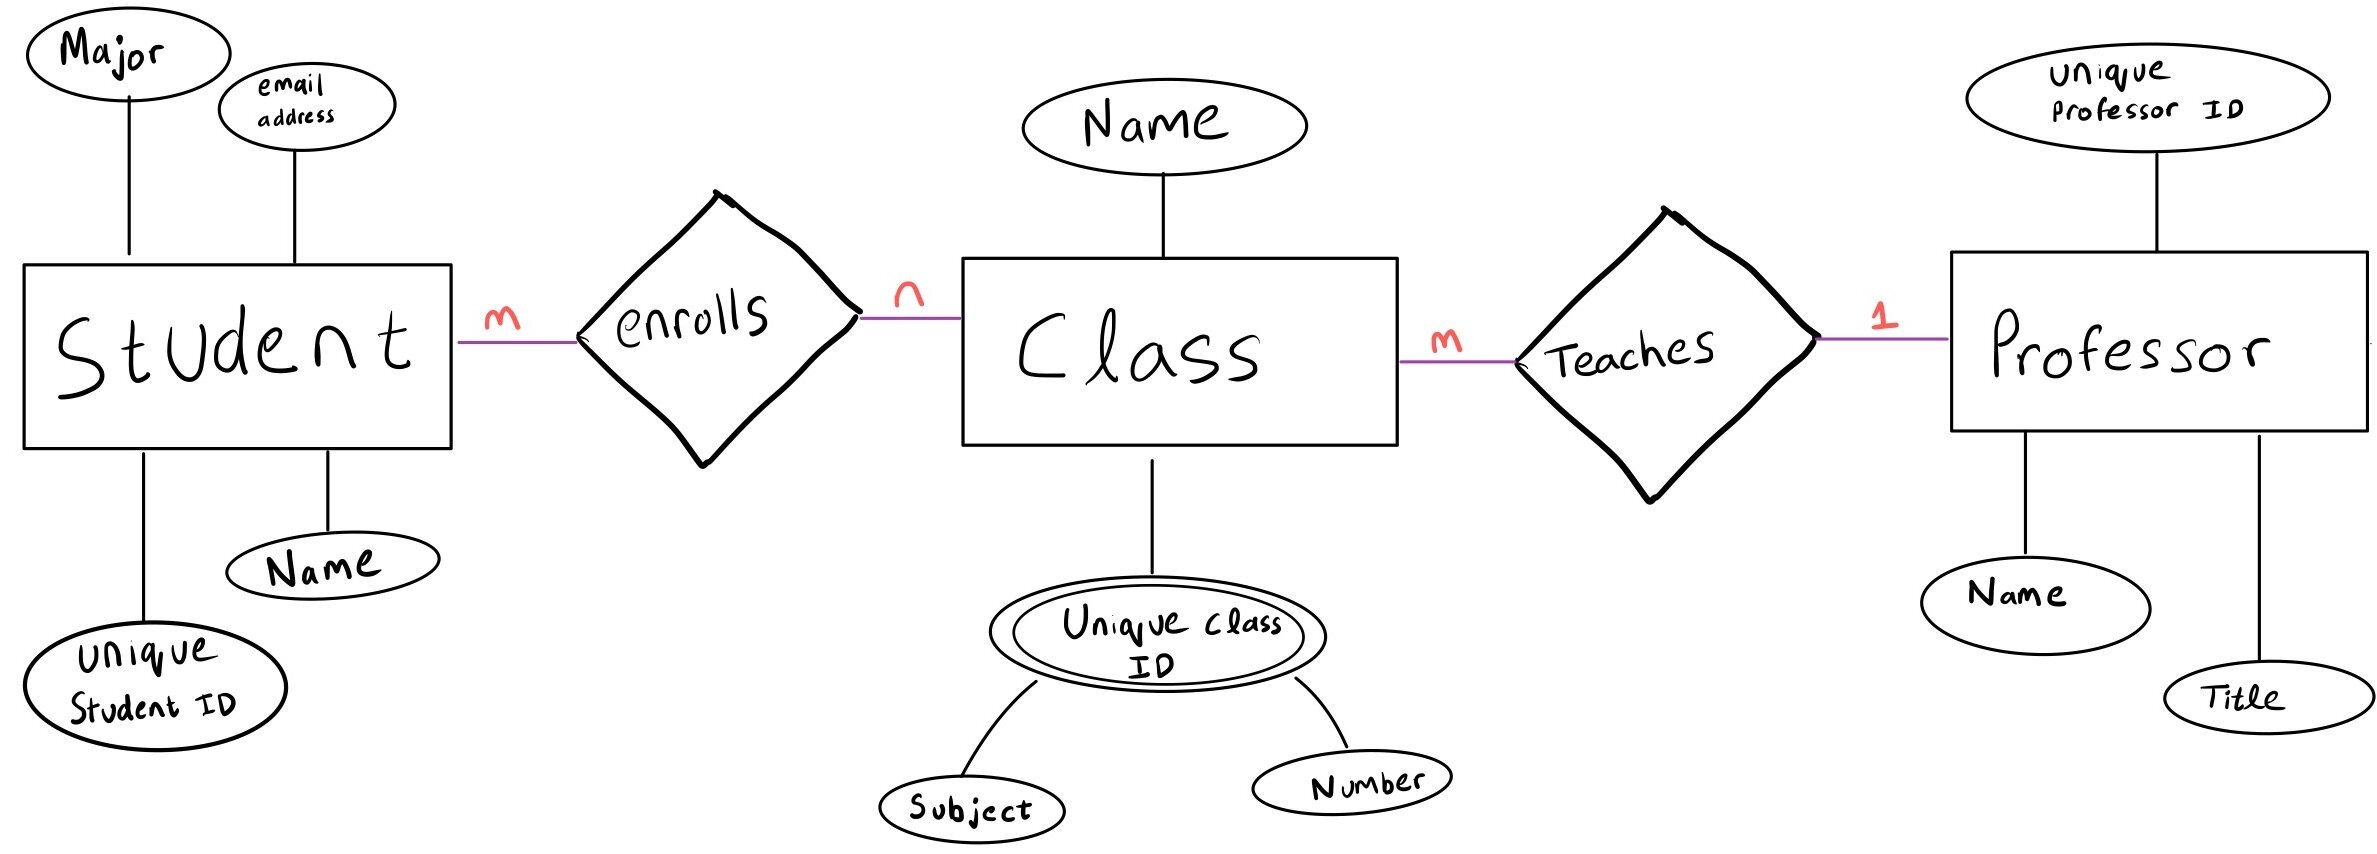

In [272]:
img = Image.open('ER-12.jpg')
img.show()
display(img)

# HW Submission

Before you submit on Gradescope (you must submit your notebook to receive credit):


1.   Restart and Run-All to make sure there's nothing wrong with your notebook
2.   **Double check that you have the correct PennID (all numbers) in the autograder**.
3. Make sure you've run all the PennGrader cells
4. Go to the "File" tab at the top left, and download both the .ipynb and .py files, renaming them as "homework2.ipynb" and "homework2.py" respectively. Upload both files to Gradescope directly!
5. Check your .ipynb file is visible under the code tab. If there is a "large file error" go back and delete all occurances of printing an entire df, and/or make your figure sizes smaller, then resubmit. Then confirm the notebook preview is now visible in your Gradescope submission.

**You MUST check that your notebook displays ALL visualizations on the Gradescope preview AND verify that the autograder finishes running and gives you your expected score (not a 0).**

**Let the course staff know ASAP if you have any issues submitting, but otherwise best of luck! Congrats on finishing the HW.**